# Rule Implementation Per Subject

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from itertools import groupby
from collections import Counter
# from jupyterthemes import jtplot
# jtplot.reset()
import os
import glob
from copy import deepcopy

In [20]:
def base_rule(data):
    """ Finds the number of points to relabel based on the base rule.
    
    if the number of consecutive motions == target > 4:
        if the next set of motions < 4 and the motion after == target:
            relabel the data
            
    Params: 
        data - the virtual game data
        
    Returns:
        total_changed_sum - the total number of data points relabeled
        percentage_changed - the percentage of data points relabeled
    """
    class_data = data[['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

    # separate into lists based on target class
    values = []
    i_flag = 0
    for i in range(1, len(class_data)):
        if class_data[i-1, 1] == class_data[i, 1]:
            pass
        else:
            values.append(class_data[i_flag:i, :])
            i_flag = i

        if i == len(class_data)-1:
            values.append(class_data[i_flag:i+1, :])

    # find RMS of MAVs at each time point
    j = 0
    for value in values:
        rms = np.zeros((len(value), 1))
        i = 0
        for row in value:
            rms[i] = np.sqrt(np.mean((row[2:])**2))
            i += 1
        value = np.hstack((value, rms))
        values[j] = value
        j += 1

    # find number of points to relabel from base rule
    total_changed = []
    expanded_vals = []
    for target in values:    
        # separate target by predicted classes
        i_flag = 0
        for i in range(1, len(target)):
            if target[i-1, 0] == target[i, 0]:
                pass
            else:
                expanded_vals.append(target[i_flag:i, :])
                i_flag = i

            if i == len(target)-1:
                expanded_vals.append(target[i_flag:i+1, :])

        # get the counts of consecutive motions of predicted classes vs target
        expanded_vals_copy = deepcopy(expanded_vals)
        j = 0
        points = []
        changed = 0
        for part in expanded_vals:
            # check if predicted == target
            if part[0,0] == part[0,1]:
                target_length = len(part)
                # boundary check to make sure not exceeding array size
                if j < len(expanded_vals)-2:
                    next_length = len(expanded_vals[j+1])
                    nextnext_length = len(expanded_vals[j+2])
                    # check if motions after == target
                    if expanded_vals[j+2][0,0] == part[0,1]:
                        points.append([target_length, next_length, nextnext_length])
                        # implement < 4 rule
                        if target_length > 4 and next_length < 4:
                            expanded_vals_copy[j+1][:,0] = part[0,1]
                            changed += len(expanded_vals_copy[j+1][:,0])
            j += 1

        if not points:
            continue
#         print(f"Consecutive motions [target, incorect, target]: \n{points}")
#         print(f"Number of relabeled points: {changed}")
        total_changed.append(changed)
        
    total_changed_sum = np.sum(total_changed)
    percentage_changed = np.around((np.sum(total_changed)/len(class_data))*100, 2)
    
    return total_changed_sum, percentage_changed

In [3]:
def augmented_rule(data):
    """ Finds the number of points to relabel based on the augmented rule.
    
    For no motion:
    if the number of consecutive motions == target > 4:
        if the next set of motions == 0 and the motion after == target and MAV RMS goes lower by 500:
            relabel as no motion 
        else:
            relabel as motion target
    For motion:
    if the number of consecutive motions == target > 4:
        if the next set of motions < 4 and the motion after == target and MAV RMS goes higher by 500:
            do nothing to the data
        else:
            relabel the data
    
    Params: 
        data - the virtual game data
        
    Returns:
        total_changed_sum - the total number of data points relabeled
        percentage_changed - the percentage of data points relabeled
    """
    class_data = data[['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

    # separate into lists based on target class
    values = []
    i_flag = 0
    for i in range(1, len(class_data)):
        if class_data[i-1, 1] == class_data[i, 1]:
            pass
        else:
            values.append(class_data[i_flag:i, :])
            i_flag = i

        if i == len(class_data)-1:
            values.append(class_data[i_flag:i+1, :])

    # find RMS of MAVs at each time point
    j = 0
    for value in values:
        rms = np.zeros((len(value), 1))
        i = 0
        for row in value:
            rms[i] = np.sqrt(np.mean((row[2:])**2))
            i += 1
        value = np.hstack((value, rms))
        values[j] = value
        j += 1

    # find number of points to relabel
    total_changed = []
    expanded_vals = []
    for target in values:    
        # separate target by predicted classes
        i_flag = 0
        for i in range(1, len(target)):
            if target[i-1, 0] == target[i, 0]:
                pass
            else:
                expanded_vals.append(target[i_flag:i, :])
                i_flag = i

            if i == len(target)-1:
                expanded_vals.append(target[i_flag:i+1, :])

        # get the counts of consecutive motions of predicted classes vs target
        expanded_vals_copy = deepcopy(expanded_vals)
        j = 0
        points = []
        changed = 0
        no_motion = 0
        rms_thresh = 0
        for part in expanded_vals:
            # check if predicted == target
            if part[0,0] == part[0,1]:
                target_length = len(part)
                # boundary check to make sure not exceeding array size
                if j < len(expanded_vals)-2:
                    next_length = len(expanded_vals[j+1])
                    nextnext_length = len(expanded_vals[j+2])
                    # check if motions after == target
                    if expanded_vals[j+2][0,0] == part[0,1]:
                        points.append([target_length, next_length, nextnext_length])
                        # implement rules
                        if target_length > 4 and next_length < 4:
                            # no motion relabeling
                            if expanded_vals[j+1][0,0] == 0:
                                value_flag = 0
                                # if RMS goes lower by 500 then relabel as no motion otherwise relabel as motion target
                                RMS_curr = np.sqrt(np.mean((expanded_vals[j][:,-1])**2))
                                RMS_next = np.sqrt(np.mean((expanded_vals[j+1][:,-1])**2))
                                RMS_nextnext = np.sqrt(np.mean((expanded_vals[j+2][:,-1])**2))
                                if RMS_next <= ((RMS_curr-500) and (RMS_nextnext-500)):
                                    expanded_vals_copy[j+1][:,1] = 0
                                    no_motion += len(expanded_vals_copy[j+1][:,1])
                                else:
                                    expanded_vals_copy[j+1][:,0] = part[0,1]
                                    changed += len(expanded_vals_copy[j+1][:,0])
                            # motion relabeling
                            else:
                                # if RMS goes higher by 500 don't relabel
                                RMS_curr = np.sqrt(np.mean((expanded_vals[j][:,-1])**2))
                                RMS_next = np.sqrt(np.mean((expanded_vals[j+1][:,-1])**2))
                                if RMS_next >= (RMS_curr+500):
                                    rms_thresh += 1
                                else:
                                    expanded_vals_copy[j+1][:,0] = part[0,1]
                                    changed += len(expanded_vals_copy[j+1][:,0])
            j += 1

        if not points:
            continue
#         print(f"Consecutive motions [target, incorect, target]: \n{points}")
#         print(f"Number of relabeled points: {changed+no_motion}")
#         print(f"Number of no motion relabels: {no_motion}")
#         print(f"Number of RMS thresholded motions: {rms_thresh}")
        total_changed.append(changed+no_motion)
        
    total_changed_sum = np.sum(total_changed)
    percentage_changed = np.around((np.sum(total_changed)/len(class_data))*100, 2)
    
    return total_changed_sum, percentage_changed

In [4]:
# Globals
all_base_rules = []
all_aug_rules = []

In [5]:
def load_data(subject):
    """ Reads in all virtual game files for one subject and saves those 
        for In the Zone.

        Params:
            subject - ID number to use.

        Returns:
            Gamedata - A list of Pandas dataframes for In the Zone data.
    """
    path = os.getcwd()
    csv_files = glob.glob(os.path.join(path, f"../Data/{subject}/VirtualGameData/VirtualArmGames_*"))
    csv_files = sorted(csv_files)
    Gamedata = []
#     print("Game data paths:")

    for i in csv_files:
        df = pd.read_csv(i)
        df = df[df['entryType'] == 0]
        if (df['gameName'] == "In the Zone").any():
            Gamedata.append(df)
#             print(i)

    return Gamedata

In [21]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#31127011_2WProsthUse")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print(f"Total outputs: {len(data)}")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print(f"Total outputs: {len(data)}")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.04894172162642918
Std dev: 0.036438374173631834
Augmented Rule: 
Mean: 0.045103527064423776
Std dev: 0.03358098441768037


In [7]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#31180011_2WProsthUse")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.010390957965554363
Std dev: 0.004672410486810603
Augmented Rule: 
Mean: 0.008497549638006245
Std dev: 0.0036029966387071907


In [8]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#32068222_2WProsthUse")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.08395938595705975
Std dev: 0.03503583221430357
Augmented Rule: 
Mean: 0.08124667756235068
Std dev: 0.03464237902725392


In [9]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#32098021_2WProsthUse")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.04982057787997414
Std dev: 0.02191894816296347
Augmented Rule: 
Mean: 0.04521576977695964
Std dev: 0.019368857032493938


In [10]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#32132721_2WProsthUse_KW")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.01891932167980247
Std dev: 0.006448396793752036
Augmented Rule: 
Mean: 0.018826497025574308
Std dev: 0.006485460786383814


In [11]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#32136722_2WProsthUse")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.08191623094952218
Std dev: 0.03717604903784557
Augmented Rule: 
Mean: 0.07702290697896715
Std dev: 0.031392836223334004


In [12]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#32195432_2WProsthUse")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.07310926229892745
Std dev: 0.04332953759292637
Augmented Rule: 
Mean: 0.0717914912145901
Std dev: 0.04162929611453564


In [13]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#51013322_2WProsthUse")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.0909363782919282
Std dev: 0.0388989788578601
Augmented Rule: 
Mean: 0.08597655408970462
Std dev: 0.03548562463532829


In [14]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#51048532_2WProsthUse")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.15246800898860965
Std dev: 0.0596823928903813
Augmented Rule: 
Mean: 0.1504626344681203
Std dev: 0.058043906153553475


In [15]:
""" Reads data in from individual participants. Only takes data where the entry type = 0.
Both In the Zone and Simon Says
"""
Gamedata = load_data("ID#52054922_2WProsthUse")

base_changed_list = []
aug_changed_list = []
for data in Gamedata:
    total_changed_sum, percentage_changed = base_rule(data)
#     print("Base Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
    normalized_sum = total_changed_sum / len(data)
    base_changed_list.append(normalized_sum)

    total_changed_sum, percentage_changed = augmented_rule(data)
#     print("Augmented Rule:")
#     print(f"Total changed: {total_changed_sum}")
#     print(f"Percentage changed: {percentage_changed}%")
#     print("")
    normalized_sum = total_changed_sum / len(data)
    aug_changed_list.append(normalized_sum)

print("Base Rule: ")
print(f"Mean: {np.mean(base_changed_list)}")
print(f"Std dev: {np.std(base_changed_list)}")
print("Augmented Rule: ")
print(f"Mean: {np.mean(aug_changed_list)}")
print(f"Std dev: {np.std(aug_changed_list)}")
all_base_rules.append([np.mean(base_changed_list), np.std(base_changed_list)])
all_aug_rules.append([np.mean(aug_changed_list), np.std(aug_changed_list)])

Base Rule: 
Mean: 0.09867771762298662
Std dev: 0.027494804319749988
Augmented Rule: 
Mean: 0.09119378356595234
Std dev: 0.025862668061853483


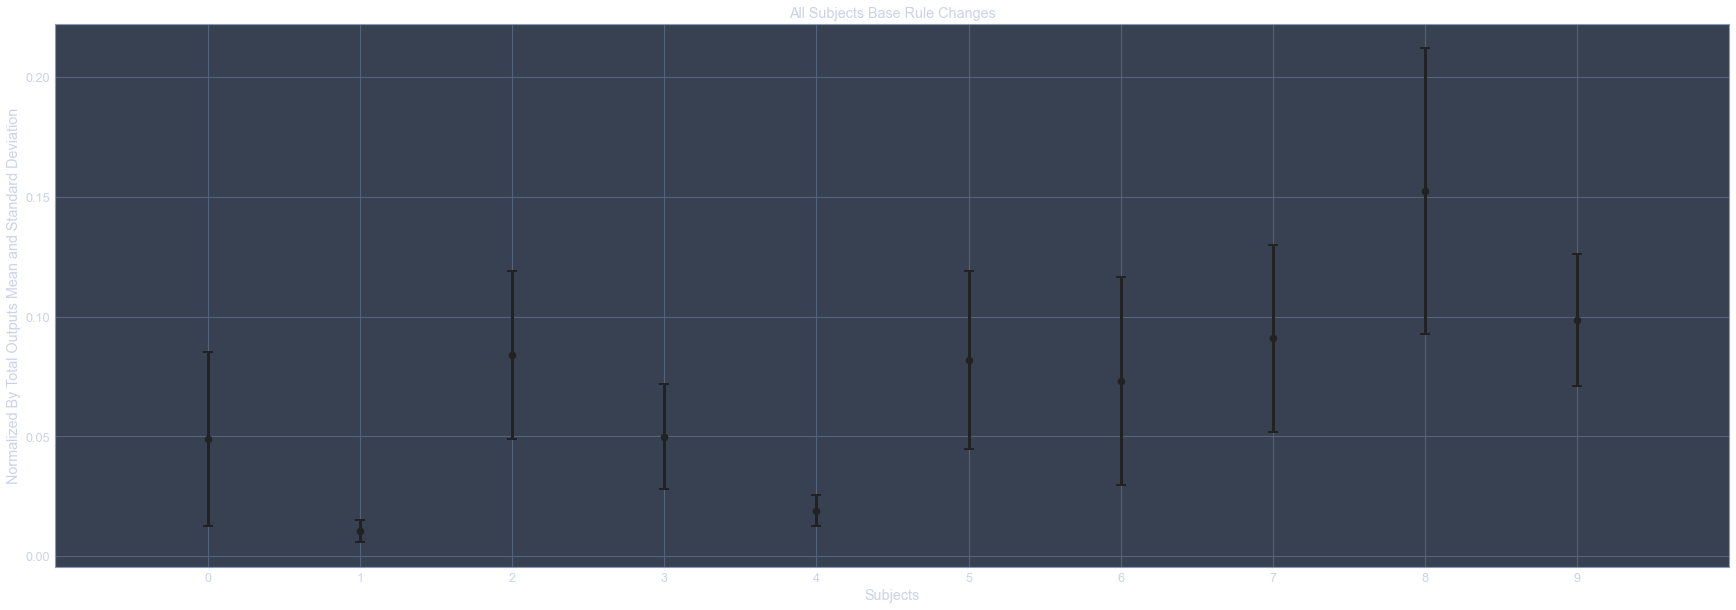

In [16]:
all_means = [i[0] for i in all_base_rules]
all_stds = [i[1] for i in all_base_rules]

with open('all_base_rules_means.csv','w') as csvfile:
    for element in all_means:
        np.savetxt(csvfile, np.array([element]), delimiter=",", fmt="%10.3f")
        
with open('all_base_rules_stds.csv','w') as csvfile:
    for element in all_stds:
        np.savetxt(csvfile, np.array([element]), delimiter=",", fmt="%10.3f")

length = len(all_base_rules)
fig = plt.figure(figsize=(30, 10))
plt.errorbar(np.arange(length), all_means, all_stds, fmt='ok', lw=2, capsize=5, elinewidth=3, markeredgewidth=2)
plt.xlim(-1, length)
plt.title("All Subjects Base Rule Changes")
plt.ylabel("Normalized By Total Outputs Mean and Standard Deviation")
plt.xlabel("Subjects")
plt.xticks(np.arange(length))
# plt.yticks(np.arange(0, 1400, 100))
plt.show()

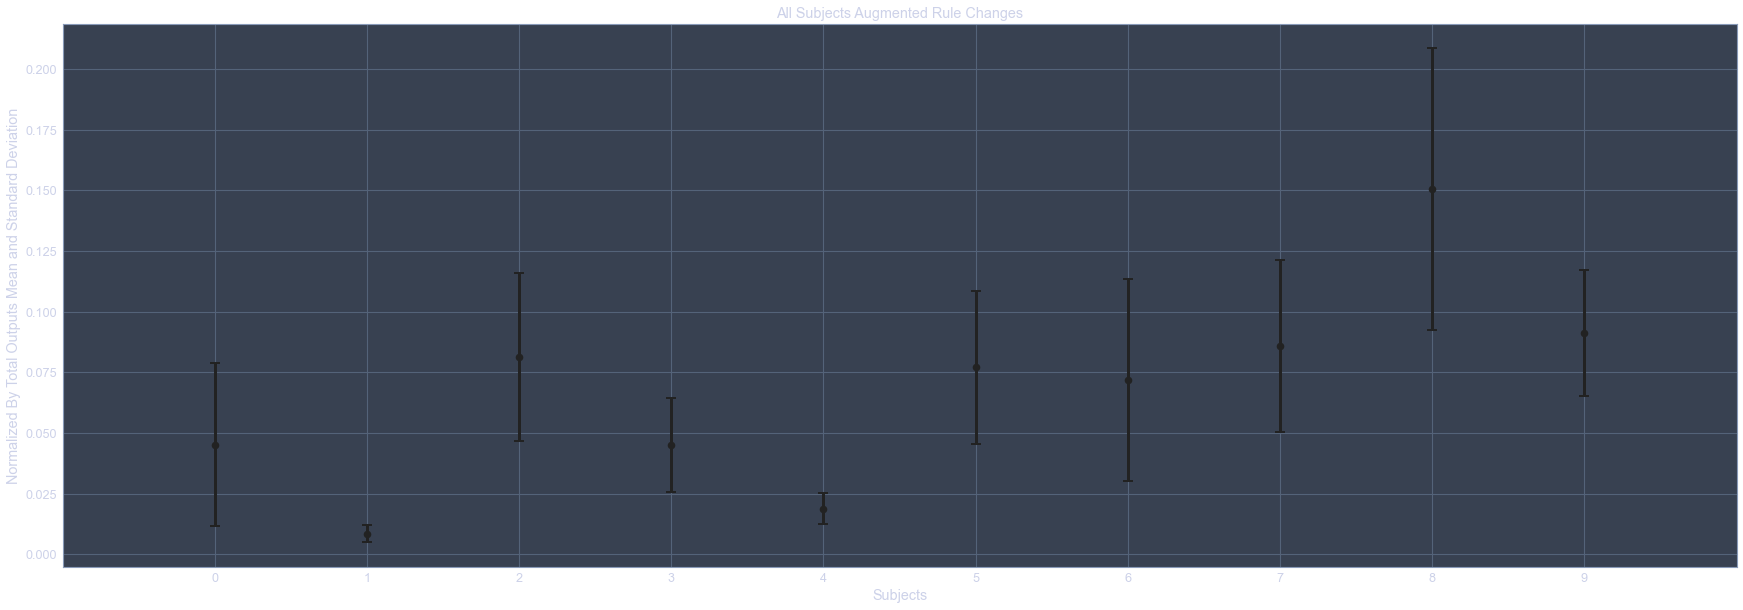

In [17]:
all_means = [i[0] for i in all_aug_rules]
all_stds = [i[1] for i in all_aug_rules]

with open('all_aug_rules_means.csv','w') as csvfile:
    for element in all_means:
        np.savetxt(csvfile, np.array([element]), delimiter=",", fmt="%10.3f")
        
with open('all_aug_rules_stds.csv','w') as csvfile:
    for element in all_stds:
        np.savetxt(csvfile, np.array([element]), delimiter=",", fmt="%10.3f")
        
length = len(all_aug_rules)
fig = plt.figure(figsize=(30, 10))
plt.errorbar(np.arange(length), all_means, all_stds, fmt='ok', lw=2, capsize=5, elinewidth=3, markeredgewidth=2)
plt.xlim(-1, length)
plt.title("All Subjects Augmented Rule Changes")
plt.ylabel("Normalized By Total Outputs Mean and Standard Deviation")
plt.xlabel("Subjects")
plt.xticks(np.arange(length))
# plt.yticks(np.arange(0, 1400, 100))
plt.show()